In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [6]:
latticeVectors = np.array([[1,0], [0,1], [-1,0], [0,-1]], dtype=np.int32)

@numba.njit
def randomWalk2D(numberOfCycles: int, numberOfParticles: int, latticeSize: int, maxCorrelationTime: int = 500, maxOrigins: int = 50):
    lattice = np.zeros((latticeSize, latticeSize), dtype=np.int32)
    
    # select random lattice sites to initialize particles
    indices = np.random.choice(latticeSize**2, size=numberOfParticles, replace=False)
    xPositions = indices % latticeSize
    yPositions = indices // latticeSize
    
    positions = np.column_stack((xPositions, yPositions))
    unwrappedPositions = positions.copy()

    # msd sampling
    msd = np.zeros((maxCorrelationTime, 2))
    counts = np.zeros(maxCorrelationTime, dtype=np.int32)
    originPositions = np.zeros((maxOrigins, numberOfParticles, 2))
    originTimes = np.zeros(maxOrigins, dtype=np.int32)
    originIndex = 0
    originInterval = 50

    accepted = 0

    for cycle in range(numberOfCycles):
        # Select particle and displacement
        particleIndex = np.random.choice(numberOfParticles)
        dx = latticeVectors[np.random.choice(4)]
        xold, yold = positions[particleIndex]
        
        # Get new position and wrap in box
        newPosition = (positions[particleIndex] + dx) % latticeSize
        xnew, ynew = newPosition
        
        # Check if lattice site is occupied
        if lattice[xnew, ynew] == 0:
            accepted += 1
            lattice[xold, yold] = 0
            lattice[xnew, ynew] = 1
            positions[particleIndex] = newPosition
            unwrappedPositions[particleIndex] += dx
    
        if (cycle > 0.25 * numberOfCycles):
            # sample msd
            if cycle % originInterval == 0:
                originTimes[originIndex] = cycle
                originPositions[originIndex] = unwrappedPositions
                originIndex = (originIndex + 1) % maxOrigins

            for i in range(min(cycle // maxOrigins, maxOrigins)):
                time_difference = cycle - originTimes[i]
                if time_difference < maxCorrelationTime:
                    counts[time_difference] += 1
                    msd[time_difference] += np.sum((unwrappedPositions - originPositions[i])**2, axis=0)

    nonZero = counts > 0
    msd[nonZero] /= counts[nonZero][:, None]

    print(f"Total accepted: {accepted}\nLattice occupation: {np.sum(lattice)}")
    return msd

def linearFit(x, y, delta=0.001, error=0.001, maxLoops=int(1e5), a=1.0, b=0.0):
    
    for _ in range(maxLoops):
        yhat = a * x - b
        mse = np.mean((yhat - y)**2)
        if mse <= error:
            return a, b
        a += delta * np.sum((yhat - y) * x)
        b += delta * np.sum(yhat-y)
    return a, b
        

In [3]:
numberOfParticles = 800
latticeSize = 40
numberOfCycles = 1000000

In [4]:
msd = randomWalk2D(numberOfCycles, numberOfParticles, latticeSize)

Total accepted: 502544
Lattice occupation: 800


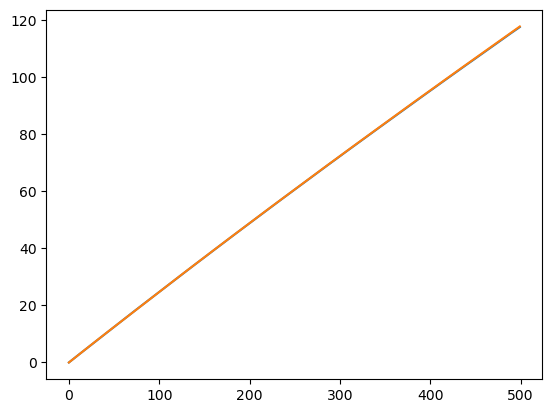

In [5]:
fig, ax = plt.subplots()
ax.plot(msd[:, 0])
ax.plot(msd[:, 1])